# Imports

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import warnings
from copy import deepcopy
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch

from assembly import Assembly
from utils import load_yaml, num_params
from utils.models import load_model

In [4]:
sns.set(font_scale=1.25, style="whitegrid")

# Ignore known warnings that come when constructing subnets.
warnings.filterwarnings("ignore", message=".*The parameter 'pretrained' is deprecated.*")
warnings.filterwarnings("ignore", message=".*Arguments other than a weight enum.*")
warnings.filterwarnings("ignore", message=".*already erased node.*")

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# print(f"Using device = {device}")

NUM_CORES = os.cpu_count()
if hasattr(os, "sched_getaffinity"):
    # This function is only available on certain platforms. When running with Slurm, it can tell us the true
    # number of cores we have access to.
    NUM_CORES = len(os.sched_getaffinity(0))
print (f"Using {NUM_CORES} cores.")

Using 8 cores.


# Cross-Test Results

Results from testing every combination of encoder vs. head for (encoder + head) models fine-tuned on various datasets.

In [5]:
df = pd.read_pickle(Path("../full-cross-test-result-with-train.pkl"))
# Filter out the RenderedSST2 dataset, it's a red herring.
df = df[(df['head_dataset'] != 'renderedSST2') & (df['encoder_dataset'] != 'renderedSST2')]
df

,head_dataset,head_loc,encoder_dataset,encoder_loc,Epoch,Overall/Train Accuracy,Overall/Test Accuracy
0,aid,experiments/finetune-tests/aid/lr-1e-3-bs-128/...,base,,0,0.431125,0.463500
1,aid,experiments/finetune-tests/aid/lr-1e-3-bs-128/...,aid,experiments/finetune-tests/aid/lr-1e-3-bs-128/...,0,0.997750,0.971500
2,aid,experiments/finetune-tests/aid/lr-1e-3-bs-128/...,cars,experiments/finetune-tests/cars/lr-1e-3-bs-128...,0,0.218375,0.217000
3,aid,experiments/finetune-tests/aid/lr-1e-3-bs-128/...,cifar10,experiments/finetune-tests/cifar10/lr-1e-3-bs-...,0,0.191500,0.172500
4,aid,experiments/finetune-tests/aid/lr-1e-3-bs-128/...,cifar100,experiments/finetune-tests/cifar100/lr-1e-3-bs...,0,0.152500,0.175000
...,...,...,...,...,...,...,...
500,ucm,experiments/finetune-tests/ucm/lr-1e-3-bs-128/...,pcam,experiments/finetune-tests/pcam/lr-1e-3-bs-128...,0,0.149405,0.147619
502,ucm,experiments/finetune-tests/ucm/lr-1e-3-bs-128/...,resisc45,experiments/finetune-tests/resisc45/lr-1e-3-bs...,0,0.823810,0.811905
503,ucm,experiments/finetune-tests/ucm/lr-1e-3-bs-128/...,sun397,experiments/finetune-tests/sun397/lr-1e-3-bs-1...,0,0.757738,0.726190
504,ucm,experiments/finetune-tests/ucm/lr-1e-3-bs-128/...,svhn,experiments/finetune-tests/svhn/lr-1e-3-bs-128...,0,0.139881,0.147619


In [6]:
rect_df = df.pivot(index="encoder_dataset", columns="head_dataset", values="Overall/Test Accuracy")
rect_df

head_dataset,FashionMNIST,aid,cars,cifar10,cifar100,dtd,emnist,eurosat,fer2013,flowers102,...,food101,gtsrb,kmnist,mnist,oxfordiiitpet,pcam,resisc45,sun397,svhn,ucm
encoder_dataset,,,,,,,,,,,,,,,,,,,,,
FashionMNIST,0.9518,0.1305,0.010694,0.2026,0.0544,0.063298,0.268429,0.280370,0.241850,0.026667,...,0.034257,0.115835,0.1935,0.2943,0.095368,0.424683,0.083333,0.023224,0.208705,0.154762
aid,0.3957,0.9715,0.023999,0.1780,0.0893,0.289894,0.206442,0.326296,0.164391,0.063415,...,0.111248,0.115994,0.1780,0.2517,0.413079,0.589996,0.619365,0.156373,0.186232,0.661905
base,0.6087,0.4635,0.054091,0.7863,0.5237,0.438830,0.271437,0.485926,0.162719,0.081301,...,0.214099,0.188994,0.2031,0.1708,0.793188,0.522614,0.411905,0.402620,0.232714,0.580952
cars,0.1645,0.2170,0.815220,0.3057,0.0988,0.154255,0.145987,0.148519,0.144609,0.065854,...,0.099683,0.153998,0.1000,0.1520,0.638965,0.509644,0.123968,0.093703,0.143324,0.302381
cifar10,0.4265,0.1725,0.012310,0.9787,0.4413,0.137766,0.291850,0.326667,0.257593,0.105691,...,0.059248,0.202534,0.1869,0.2644,0.333787,0.569611,0.180476,0.053249,0.255378,0.211905
cifar100,0.4678,0.1750,0.016787,0.8189,0.8623,0.114894,0.416958,0.340741,0.219142,0.075610,...,0.051446,0.258749,0.1700,0.3277,0.162125,0.499969,0.149206,0.050126,0.209127,0.092857
dtd,0.2082,0.3745,0.024123,0.2967,0.1543,0.746809,0.117212,0.490370,0.178601,0.074959,...,0.101941,0.157641,0.1303,0.1113,0.665940,0.627808,0.266032,0.186952,0.233636,0.411905
emnist,0.1458,0.0580,0.004352,0.1512,0.0214,0.061170,0.998146,0.206296,0.176512,0.007642,...,0.012436,0.075059,0.1628,0.3529,0.030790,0.579437,0.053968,0.003526,0.272511,0.083333
eurosat,0.2721,0.3170,0.026735,0.2243,0.0790,0.191489,0.178850,0.986667,0.286013,0.185366,...,0.066891,0.086540,0.1549,0.1003,0.142234,0.599030,0.255556,0.042821,0.200791,0.259524


In [7]:
rect_df = rect_df.reindex(columns=df["head_dataset"].unique(), level="head_dataset")
rect_df = rect_df.reindex(index=df["encoder_dataset"].unique(), level="encoder_dataset")
rect_df

head_dataset,aid,cars,cifar10,cifar100,dtd,emnist,eurosat,FashionMNIST,fer2013,flowers102,...,food101,gtsrb,kmnist,mnist,oxfordiiitpet,pcam,resisc45,sun397,svhn,ucm
encoder_dataset,,,,,,,,,,,,,,,,,,,,,
base,0.4635,0.054091,0.7863,0.5237,0.438830,0.271437,0.485926,0.6087,0.162719,0.081301,...,0.214099,0.188994,0.2031,0.1708,0.793188,0.522614,0.411905,0.402620,0.232714,0.580952
aid,0.9715,0.023999,0.1780,0.0893,0.289894,0.206442,0.326296,0.3957,0.164391,0.063415,...,0.111248,0.115994,0.1780,0.2517,0.413079,0.589996,0.619365,0.156373,0.186232,0.661905
cars,0.2170,0.815220,0.3057,0.0988,0.154255,0.145987,0.148519,0.1645,0.144609,0.065854,...,0.099683,0.153998,0.1000,0.1520,0.638965,0.509644,0.123968,0.093703,0.143324,0.302381
cifar10,0.1725,0.012310,0.9787,0.4413,0.137766,0.291850,0.326667,0.4265,0.257593,0.105691,...,0.059248,0.202534,0.1869,0.2644,0.333787,0.569611,0.180476,0.053249,0.255378,0.211905
cifar100,0.1750,0.016787,0.8189,0.8623,0.114894,0.416958,0.340741,0.4678,0.219142,0.075610,...,0.051446,0.258749,0.1700,0.3277,0.162125,0.499969,0.149206,0.050126,0.209127,0.092857
dtd,0.3745,0.024123,0.2967,0.1543,0.746809,0.117212,0.490370,0.2082,0.178601,0.074959,...,0.101941,0.157641,0.1303,0.1113,0.665940,0.627808,0.266032,0.186952,0.233636,0.411905
emnist,0.0580,0.004352,0.1512,0.0214,0.061170,0.998146,0.206296,0.1458,0.176512,0.007642,...,0.012436,0.075059,0.1628,0.3529,0.030790,0.579437,0.053968,0.003526,0.272511,0.083333
eurosat,0.3170,0.026735,0.2243,0.0790,0.191489,0.178850,0.986667,0.2721,0.286013,0.185366,...,0.066891,0.086540,0.1549,0.1003,0.142234,0.599030,0.255556,0.042821,0.200791,0.259524
FashionMNIST,0.1305,0.010694,0.2026,0.0544,0.063298,0.268429,0.280370,0.9518,0.241850,0.026667,...,0.034257,0.115835,0.1935,0.2943,0.095368,0.424683,0.083333,0.023224,0.208705,0.154762


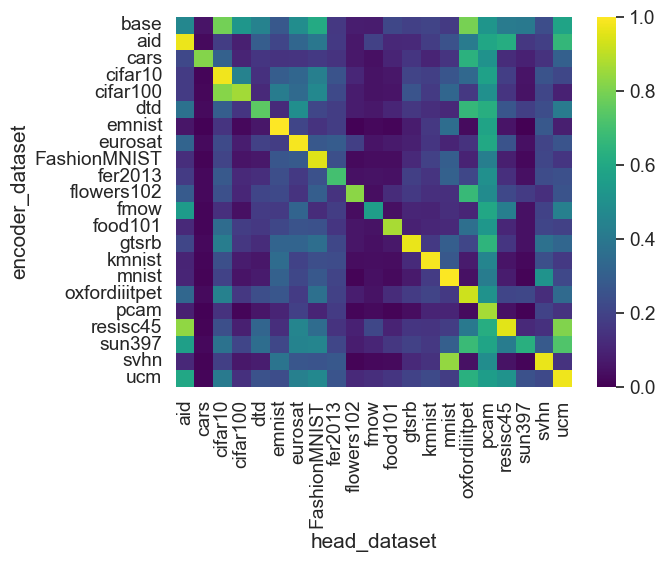

In [8]:
_ = sns.heatmap(rect_df, annot=False, vmin=0.0, vmax=1.0, xticklabels=True, yticklabels=True, cmap="viridis")
plt.savefig("../cross-test-heatmap.pdf", bbox_inches="tight")
plt.savefig("../cross-test-heatmap.png", bbox_inches="tight")

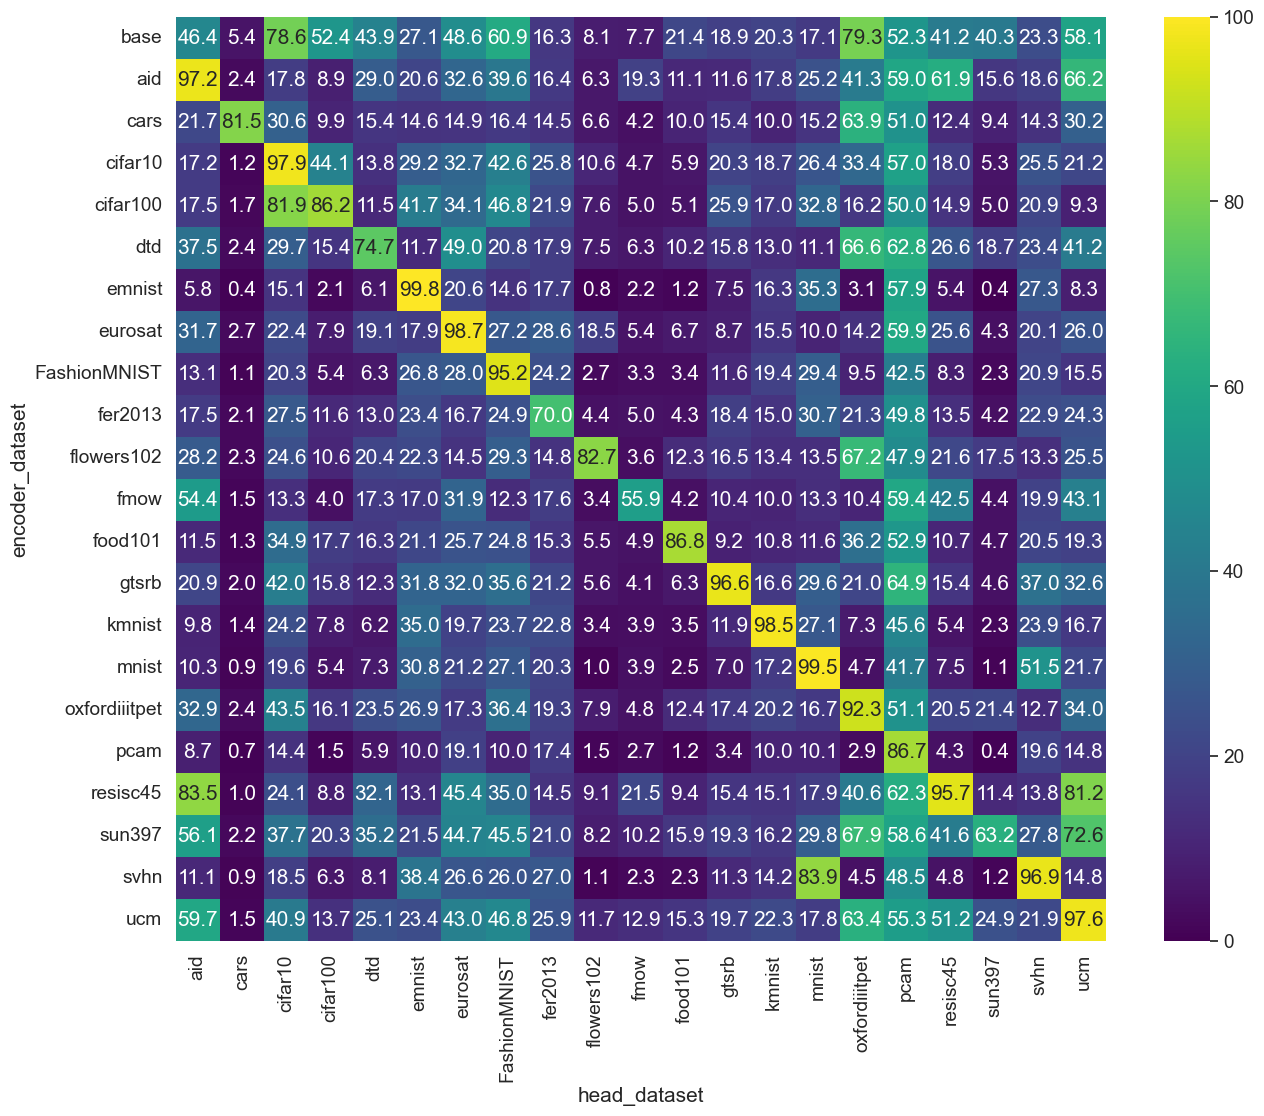

In [9]:
fig = plt.figure(figsize=(15, 12))
_ = sns.heatmap(rect_df * 100, vmin=0.0, vmax=100.0, xticklabels=True, yticklabels=True, cmap="viridis",
                annot=True, fmt=".1f")
plt.savefig("../cross-test-heatmap-labeled.pdf", bbox_inches="tight")
plt.savefig("../cross-test-heatmap-labeled.png", bbox_inches="tight")

In [10]:
rect_train_df = df.pivot(index="encoder_dataset", columns="head_dataset", values="Overall/Train Accuracy")
rect_train_df

head_dataset,FashionMNIST,aid,cars,cifar10,cifar100,dtd,emnist,eurosat,fer2013,flowers102,...,food101,gtsrb,kmnist,mnist,oxfordiiitpet,pcam,resisc45,sun397,svhn,ucm
encoder_dataset,,,,,,,,,,,,,,,,,,,,,
FashionMNIST,0.981383,0.118875,0.010928,0.19398,0.04714,0.063830,0.251454,0.279907,0.249251,0.035294,...,0.028647,0.118431,0.181400,0.287183,0.091576,0.467251,0.088783,0.021511,0.206039,0.145238
aid,0.323300,0.997750,0.029347,0.15878,0.07486,0.309043,0.195662,0.352685,0.187914,0.097059,...,0.093188,0.108296,0.193467,0.220867,0.357065,0.598206,0.611481,0.166599,0.203568,0.680357
base,0.540533,0.431125,0.063851,0.72186,0.44078,0.457447,0.324317,0.456898,0.184396,0.141176,...,0.186297,0.209985,0.207950,0.249983,0.766848,0.507538,0.385132,0.459093,0.221791,0.577381
cars,0.175350,0.218375,0.985142,0.27772,0.08400,0.150000,0.142083,0.170046,0.154859,0.099020,...,0.089201,0.166892,0.123617,0.157550,0.605435,0.517902,0.140159,0.097582,0.143752,0.313095
cifar10,0.386250,0.191500,0.011174,0.98318,0.40404,0.130851,0.269267,0.359398,0.263776,0.121569,...,0.050891,0.211824,0.219633,0.242600,0.282065,0.598824,0.187037,0.045239,0.244820,0.184524
cifar100,0.420733,0.152500,0.017436,0.78896,0.95096,0.105851,0.397813,0.362315,0.225148,0.085294,...,0.042653,0.243281,0.230883,0.283517,0.129620,0.499355,0.142593,0.044030,0.210093,0.089881
dtd,0.212467,0.331500,0.027873,0.26664,0.12766,0.946809,0.129892,0.475324,0.180913,0.097059,...,0.088040,0.163026,0.121433,0.129933,0.611413,0.630070,0.276614,0.187960,0.237503,0.424405
emnist,0.140967,0.053500,0.005403,0.14948,0.01820,0.055319,0.997633,0.210694,0.173703,0.009804,...,0.011960,0.074174,0.200283,0.369517,0.031250,0.533432,0.048413,0.002771,0.224617,0.061310
eurosat,0.273550,0.309750,0.026031,0.20524,0.07352,0.189096,0.176242,0.993750,0.281783,0.169608,...,0.057848,0.089865,0.160617,0.122167,0.122826,0.593117,0.239630,0.041259,0.197917,0.249405


In [11]:
rect_train_df = rect_train_df.reindex(columns=df["head_dataset"].unique(), level="head_dataset")
rect_train_df = rect_train_df.reindex(index=df["encoder_dataset"].unique(), level="encoder_dataset")
rect_train_df

head_dataset,aid,cars,cifar10,cifar100,dtd,emnist,eurosat,FashionMNIST,fer2013,flowers102,...,food101,gtsrb,kmnist,mnist,oxfordiiitpet,pcam,resisc45,sun397,svhn,ucm
encoder_dataset,,,,,,,,,,,,,,,,,,,,,
base,0.431125,0.063851,0.72186,0.44078,0.457447,0.324317,0.456898,0.540533,0.184396,0.141176,...,0.186297,0.209985,0.207950,0.249983,0.766848,0.507538,0.385132,0.459093,0.221791,0.577381
aid,0.997750,0.029347,0.15878,0.07486,0.309043,0.195662,0.352685,0.323300,0.187914,0.097059,...,0.093188,0.108296,0.193467,0.220867,0.357065,0.598206,0.611481,0.166599,0.203568,0.680357
cars,0.218375,0.985142,0.27772,0.08400,0.150000,0.142083,0.170046,0.175350,0.154859,0.099020,...,0.089201,0.166892,0.123617,0.157550,0.605435,0.517902,0.140159,0.097582,0.143752,0.313095
cifar10,0.191500,0.011174,0.98318,0.40404,0.130851,0.269267,0.359398,0.386250,0.263776,0.121569,...,0.050891,0.211824,0.219633,0.242600,0.282065,0.598824,0.187037,0.045239,0.244820,0.184524
cifar100,0.152500,0.017436,0.78896,0.95096,0.105851,0.397813,0.362315,0.420733,0.225148,0.085294,...,0.042653,0.243281,0.230883,0.283517,0.129620,0.499355,0.142593,0.044030,0.210093,0.089881
dtd,0.331500,0.027873,0.26664,0.12766,0.946809,0.129892,0.475324,0.212467,0.180913,0.097059,...,0.088040,0.163026,0.121433,0.129933,0.611413,0.630070,0.276614,0.187960,0.237503,0.424405
emnist,0.053500,0.005403,0.14948,0.01820,0.055319,0.997633,0.210694,0.140967,0.173703,0.009804,...,0.011960,0.074174,0.200283,0.369517,0.031250,0.533432,0.048413,0.002771,0.224617,0.061310
eurosat,0.309750,0.026031,0.20524,0.07352,0.189096,0.176242,0.993750,0.273550,0.281783,0.169608,...,0.057848,0.089865,0.160617,0.122167,0.122826,0.593117,0.239630,0.041259,0.197917,0.249405
FashionMNIST,0.118875,0.010928,0.19398,0.04714,0.063830,0.251454,0.279907,0.981383,0.249251,0.035294,...,0.028647,0.118431,0.181400,0.287183,0.091576,0.467251,0.088783,0.021511,0.206039,0.145238


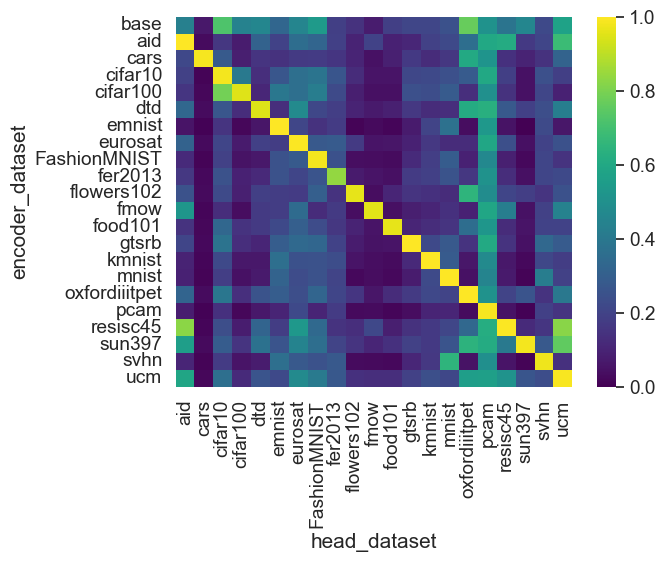

In [12]:
_ = sns.heatmap(rect_train_df, annot=False, vmin=0.0, vmax=1.0, xticklabels=True, yticklabels=True, cmap="viridis")
plt.savefig("../cross-test-heatmap-train.pdf", bbox_inches="tight")
plt.savefig("../cross-test-heatmap-train.png", bbox_inches="tight")

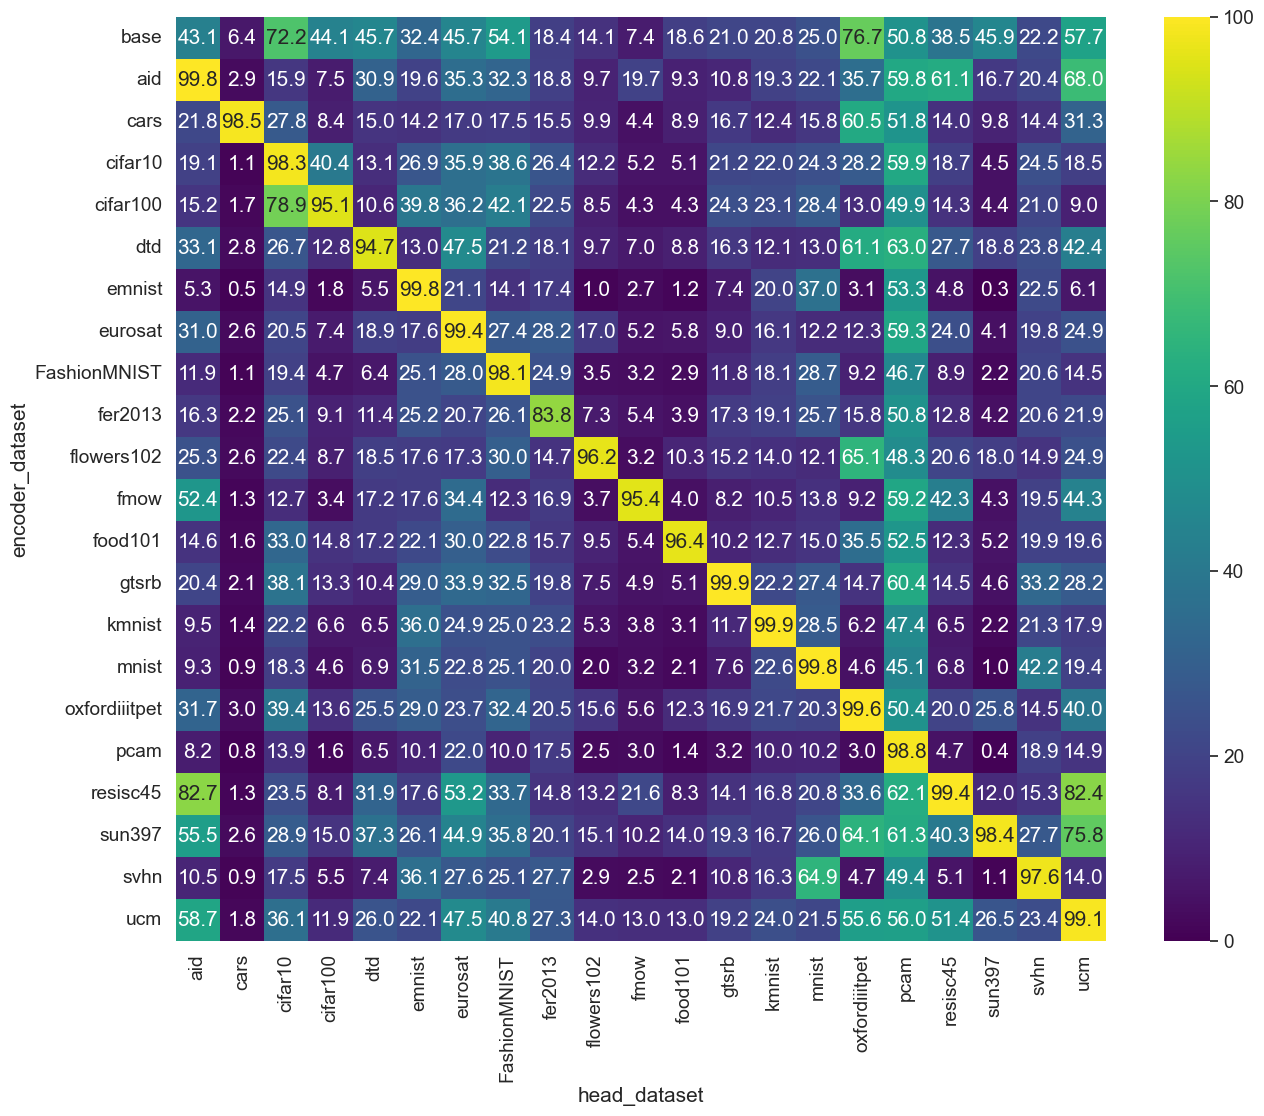

In [13]:
fig = plt.figure(figsize=(15, 12))
_ = sns.heatmap(rect_train_df * 100, vmin=0.0, vmax=100.0, xticklabels=True, yticklabels=True, cmap="viridis",
                annot=True, fmt=".1f")
plt.savefig("../cross-test-heatmap-labeled-train.pdf", bbox_inches="tight")
plt.savefig("../cross-test-heatmap-labeled-train.png", bbox_inches="tight")

Instead of plotting raw accuracy, plot accuracy normalized by number of classes. For example:
- For 2 classes 50% is just random chance. You should do way better than this.
- For 100 classes, 1% is random chance but 50% is quite good.

So, we normalize: $ \frac{a - 1/n}{100 - 1/n}  $

In [ ]:
class_counts = [
    30,   # aid
    196,  # cars
    10,   # cifar10
    100,  # cifar100
    47,   # dtd
    62,   # emnist
    10,   # eurosat
    10,   # FashionMNIST
    7,    # fer2013
    102,  # flowers102
    62,   # fmow
    101,  # food101
    43,   # gtsrb
    10,   # kmnist
    10,   # mnist
    37,   # oxfordiiitpet
    2,    # pcam
    45,   # resisc45
    397,  # sun397
    10,   # svhn
    21    # ucm
]

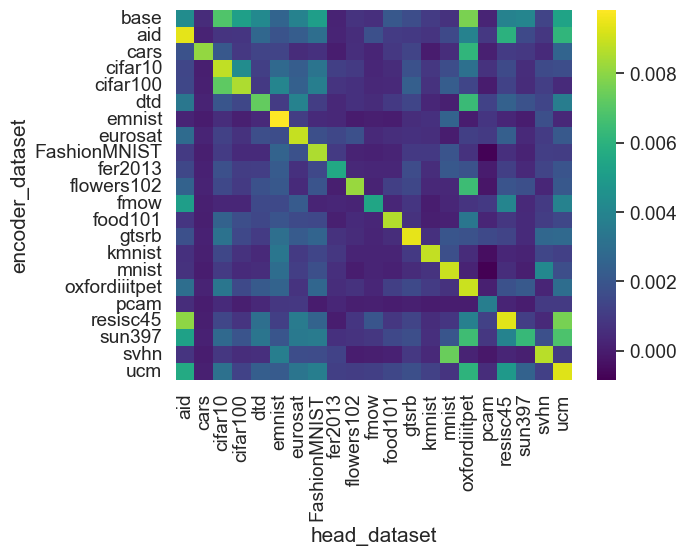

In [37]:
# fig = plt.figure(figsize=(15, 12))
random_chance = 1 / np.array(class_counts)
# norm_df = rect_df / random_chance
norm_df = (rect_df - random_chance) / (100 - random_chance)
_ = sns.heatmap(norm_df, annot=False, xticklabels=True, yticklabels=True, cmap="viridis")
plt.savefig("../cross-test-heatmap-normalized.pdf", bbox_inches="tight")
plt.savefig("../cross-test-heatmap-normalized.png", bbox_inches="tight")

# Counting Compute

Figuring out how to count params and FLOPs, or whatever might be a good proxy for amount of compute.

In [8]:
from fvcore.nn import FlopCountAnalysis
from torchtnt.utils.flops import FlopTensorDispatchMode

def print_assembly_sizes(cfile):
    cfg = load_yaml(cfile)
    assembly = cfg.get("assembly", cfg.get("stages", cfg.get("src_stages")))
    model = Assembly(assembly, cfg.get("head"), input_shape=[3, 224, 224])
    print_sizes(model)


def print_sizes(model):
    model.train()
    print(f"Number of parameters: {num_params(model):.3e}")
    if hasattr(model, "parts"):
        for i, p in enumerate(model.parts):
            print(f"Num params in part {i+1} ({p.__class__.__name__}): {num_params(p):.3e}")

    dummy_img = torch.randn(1, 3, 224, 224)
    flops = FlopCountAnalysis(model, dummy_img)
    print(f"\nfvcore FLOPs: {flops.total():.3e}")
    # print(f"fvcore FLOPs by module: {flops.by_module()}")
    # print(f"fvcore FLOPs by operator: {flops.by_operator()}")
    with FlopTensorDispatchMode(model) as ftdm:
        _ = model(dummy_img)
        print(f"\nTorchTNT FLOPs: {sum(ftdm.flop_counts[''].values()):.3e}")
        # print(f"\nTorchTNT FLOPs breakdown:")
        # for k, v in ftdm.flop_counts.items():
        #     print(f"    {k}: {v:.3e}")

W0121 22:36:52.675000 82362 site-packages/torch/distributed/elastic/multiprocessing/redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.


In [38]:
print_assembly_sizes(Path("../across-scales/mobilenet-v3.yml"))

Number of parameters: 5.483e+06
Num params in part 1 (Subnet): 4.368e+03
Num params in part 2 (Subnet): 4.440e+03
Num params in part 3 (Subnet): 1.033e+04
Num params in part 4 (Subnet): 4.198e+04
Num params in part 5 (Subnet): 3.208e+04
Num params in part 6 (Subnet): 6.993e+05
Num params in part 7 (Subnet): 4.292e+05
Num params in part 8 (Subnet): 4.261e+06

fvcore FLOPs: 2.386e+08

TorchTNT FLOPs: 2.166e+08


In [39]:
print_assembly_sizes(Path("../across-scales/resnet-50.yml"))

Number of parameters: 2.556e+07
Num params in part 1 (Subnet): 8.454e+04
Num params in part 2 (Subnet): 1.408e+05
Num params in part 3 (Subnet): 3.794e+05
Num params in part 4 (Subnet): 8.402e+05
Num params in part 5 (Subnet): 1.512e+06
Num params in part 6 (Subnet): 5.586e+06
Num params in part 7 (Subnet): 6.040e+06
Num params in part 8 (Subnet): 1.097e+07

fvcore FLOPs: 4.145e+09

TorchTNT FLOPs: 4.089e+09


In [40]:
print_assembly_sizes(Path("../across-scales/swin-t.yml"))

Number of parameters: 2.829e+07
Num params in part 1 (Subnet): 4.896e+03
Num params in part 2 (Subnet): 2.247e+05
Num params in part 3 (Subnet): 7.450e+04
Num params in part 4 (Subnet): 8.918e+05
Num params in part 5 (Subnet): 2.964e+05
Num params in part 6 (Subnet): 1.066e+07
Num params in part 7 (Subnet): 1.183e+06
Num params in part 8 (Subnet): 1.495e+07


parts.1.net.features.1.0.stochastic_depth



fvcore FLOPs: 4.509e+09

TorchTNT FLOPs: 4.491e+09


In [46]:
print_sizes(load_model("vit_small_patch16_224.augreg_in1k", "timm", pretrained=False))

blocks.0.attn.attn_drop, blocks.1.attn.attn_drop, blocks.10.attn.attn_drop, blocks.11.attn.attn_drop, blocks.2.attn.attn_drop, blocks.3.attn.attn_drop, blocks.4.attn.attn_drop, blocks.5.attn.attn_drop, blocks.6.attn.attn_drop, blocks.7.attn.attn_drop, blocks.8.attn.attn_drop, blocks.9.attn.attn_drop


Number of parameters: 2.205e+07

fvcore FLOPs: 4.251e+09

TorchTNT FLOPs: 4.241e+09


In [74]:
print_sizes(load_model("resnet18", "pytorch", pretrained=False))

Number of parameters: 1.169e+07

fvcore FLOPs: 1.827e+09

TorchTNT FLOPs: 1.814e+09


Below: demonstrating how the number of params and FLOPs in a ResNet BottleneckBlock are actually much smaller than a single conv3x3 layer.

In [58]:
# Assembly equivalent to a ResNet-50.
assembly_config = [
    {"Subnet": {
        "backend": "timm",
        "model_name": "resnet50.a1_in1k",
        "block_input": "x",
        "block_output": "layer2.3",
        "in_format": "img",  # layer1.0 input is [64, 56, 56].
        "out_format": ["img", [512, 28, 28]],
    }},
    {"Subnet": {  # Downsample block
        "backend": "timm",
        "model_name": "resnet50.a1_in1k",
        "block_input": "layer3.0",
        "block_output": "layer3.0",
        "in_format": ["img", [512, 28, 28]],
        "out_format": ["img", [1024, 14, 14]],
    }},
    {"Subnet": {
        "backend": "timm",
        "model_name": "resnet50.a1_in1k",
        "block_input": "layer3.1",
        "block_output": "fc",
        "in_format": ["img", [1024, 14, 14]],
        "out_format": "vector",
    }},
]

def newcfg():
    return deepcopy(assembly_config)


model = Assembly(newcfg(), input_shape=[3, 224, 224])
print_sizes(model)

Number of parameters: 2.556e+07
Num params in part 1 (Subnet): 1.445e+06
Num params in part 2 (Subnet): 1.512e+06
Num params in part 3 (Subnet): 2.260e+07

fvcore FLOPs: 4.145e+09

TorchTNT FLOPs: 4.089e+09


In [59]:
from launch_scaling_experiments import linear, stitch, conv3x3, bottleneck, stitch_no_downsample

gap = {
    "blocks_to_drop": [1, 1],
    "num_downsamples": 1,
}

In [60]:
conv3x3_assembly = stitch(newcfg(), newcfg(), gap, conv3x3)
model = Assembly(conv3x3_assembly, input_shape=[3, 224, 224])
print_sizes(model)

Number of parameters: 2.877e+07
Num params in part 1 (Subnet): 1.445e+06
Num params in part 2 (SimpleAdapter): 4.723e+06
Num params in part 3 (Subnet): 2.260e+07

fvcore FLOPs: 4.696e+09

TorchTNT FLOPs: 4.642e+09


In [61]:
bottleneck_assembly = stitch(newcfg(), newcfg(), gap, bottleneck)
model = Assembly(bottleneck_assembly, input_shape=[3, 224, 224])
print_sizes(model)

Number of parameters: 2.556e+07
Num params in part 1 (Subnet): 1.445e+06
Num params in part 2 (ResNetBottleneck): 1.512e+06
Num params in part 3 (Subnet): 2.260e+07

fvcore FLOPs: 4.067e+09

TorchTNT FLOPs: 4.012e+09


In [62]:
bottleneck_no_downsample_assembly = stitch_no_downsample(newcfg(), newcfg(), gap, bottleneck)
model = Assembly(bottleneck_no_downsample_assembly, input_shape=[3, 224, 224])
print_sizes(model)

Number of parameters: 2.556e+07
Num params in part 1 (Subnet): 1.445e+06
Num params in part 2 (ResNetBottleneck): 1.512e+06
Num params in part 3 (Subnet): 2.260e+07



fvcore FLOPs: 1.070e+10

TorchTNT FLOPs: 1.060e+10


In [63]:
linear_assembly = stitch(newcfg(), newcfg(), gap, linear)
model = Assembly(linear_assembly, input_shape=[3, 224, 224])
print_sizes(model)

Number of parameters: 2.457e+07
Num params in part 1 (Subnet): 1.445e+06
Num params in part 2 (SimpleAdapter): 5.284e+05
Num params in part 3 (Subnet): 2.260e+07

fvcore FLOPs: 3.906e+09

TorchTNT FLOPs: 3.851e+09


In [64]:
linear_no_downsample_assembly = stitch_no_downsample(newcfg(), newcfg(), gap, linear)
model = Assembly(linear_no_downsample_assembly, input_shape=[3, 224, 224])
print_sizes(model)

Number of parameters: 2.457e+07
Num params in part 1 (Subnet): 1.445e+06
Num params in part 2 (SimpleAdapter): 5.284e+05
Num params in part 3 (Subnet): 2.260e+07



fvcore FLOPs: 1.111e+10

TorchTNT FLOPs: 1.102e+10


# Printing Model Computation Graph

A cell for inspecting the computation graph of a model.

In [27]:
import math
import timm
import torch
import torchvision
from torch import fx
from utils import num_params
from utils.subgraphs import _get_leaf_modules_for_ops, NodePathTracer

# We could load a model either from Torchvision or timm.
# model = torchvision.models.swin_t()
model = torchvision.models.resnet50()
# model = timm.create_model("resnet50.a1_in1k")
# model = timm.create_model("mobilenetv3_large_100.ra_in1k")
# print(model)
tracer = NodePathTracer(autowrap_modules=(math, torchvision.ops), leaf_modules=_get_leaf_modules_for_ops())
graph = tracer.trace(model)
print_sizes(model)
# print(f"Number of parameters in graph: {num_params(fx.GraphModule(tracer.root, graph, model.__class__.__name__)):.3e}")

Number of parameters: 2.556e+07



fvcore FLOPs: 4.145e+09

TorchTNT FLOPs: 4.089e+09


In [39]:
print(graph)
# graph.print_tabular()

graph():
    %x : torch.Tensor [num_users=1] = placeholder[target=x]
    %conv1 : [num_users=1] = call_module[target=conv1](args = (%x,), kwargs = {})
    %bn1 : [num_users=1] = call_module[target=bn1](args = (%conv1,), kwargs = {})
    %relu : [num_users=1] = call_module[target=relu](args = (%bn1,), kwargs = {})
    %maxpool : [num_users=2] = call_module[target=maxpool](args = (%relu,), kwargs = {})
    %layer1_0_conv1 : [num_users=1] = call_module[target=layer1.0.conv1](args = (%maxpool,), kwargs = {})
    %layer1_0_bn1 : [num_users=1] = call_module[target=layer1.0.bn1](args = (%layer1_0_conv1,), kwargs = {})
    %layer1_0_relu : [num_users=1] = call_module[target=layer1.0.relu](args = (%layer1_0_bn1,), kwargs = {})
    %layer1_0_conv2 : [num_users=1] = call_module[target=layer1.0.conv2](args = (%layer1_0_relu,), kwargs = {})
    %layer1_0_bn2 : [num_users=1] = call_module[target=layer1.0.bn2](args = (%layer1_0_conv2,), kwargs = {})
    %layer1_0_relu_1 : [num_users=1] = call_module[

In [40]:
for node, qualname in tracer.node_to_qualname.items():
    print(f"{qualname} --- {node}")

x --- x
conv1 --- conv1
bn1 --- bn1
relu --- relu
maxpool --- maxpool
layer1.0.conv1 --- layer1_0_conv1
layer1.0.bn1 --- layer1_0_bn1
layer1.0.relu --- layer1_0_relu
layer1.0.conv2 --- layer1_0_conv2
layer1.0.bn2 --- layer1_0_bn2
layer1.0.relu_1 --- layer1_0_relu_1
layer1.0.conv3 --- layer1_0_conv3
layer1.0.bn3 --- layer1_0_bn3
layer1.0.downsample.0 --- layer1_0_downsample_0
layer1.0.downsample.1 --- layer1_0_downsample_1
layer1.0.add --- add
layer1.0.relu_2 --- layer1_0_relu_2
layer1.1.conv1 --- layer1_1_conv1
layer1.1.bn1 --- layer1_1_bn1
layer1.1.relu --- layer1_1_relu
layer1.1.conv2 --- layer1_1_conv2
layer1.1.bn2 --- layer1_1_bn2
layer1.1.relu_1 --- layer1_1_relu_1
layer1.1.conv3 --- layer1_1_conv3
layer1.1.bn3 --- layer1_1_bn3
layer1.1.add --- add_1
layer1.1.relu_2 --- layer1_1_relu_2
layer1.2.conv1 --- layer1_2_conv1
layer1.2.bn1 --- layer1_2_bn1
layer1.2.relu --- layer1_2_relu
layer1.2.conv2 --- layer1_2_conv2
layer1.2.bn2 --- layer1_2_bn2
layer1.2.relu_1 --- layer1_2_relu_1
la

## Testing Satlas Weights

In [37]:
from huggingface_hub import hf_hub_download

file_name = "sentinel2_resnet50_si_rgb.pth"
weights_path = hf_hub_download(repo_id="allenai/satlas-pretrain", filename=file_name)
state_dict = torch.load(weights_path, map_location="cpu")
for name in state_dict.keys():
    print(name)

# Extract just the backbone parameters from the full state dict.
# backbone_prefix = 'backbone.resnet.'
# backbone_state_dict = {k[len(backbone_prefix):]: v for k, v in state_dict.items() if k.startswith(backbone_prefix)}
# model = torchvision.models.resnet50()
# model.load_state_dict(backbone_state_dict)

backbone.resnet.conv1.weight
backbone.resnet.bn1.weight
backbone.resnet.bn1.bias
backbone.resnet.bn1.running_mean
backbone.resnet.bn1.running_var
backbone.resnet.bn1.num_batches_tracked
backbone.resnet.layer1.0.conv1.weight
backbone.resnet.layer1.0.bn1.weight
backbone.resnet.layer1.0.bn1.bias
backbone.resnet.layer1.0.bn1.running_mean
backbone.resnet.layer1.0.bn1.running_var
backbone.resnet.layer1.0.bn1.num_batches_tracked
backbone.resnet.layer1.0.conv2.weight
backbone.resnet.layer1.0.bn2.weight
backbone.resnet.layer1.0.bn2.bias
backbone.resnet.layer1.0.bn2.running_mean
backbone.resnet.layer1.0.bn2.running_var
backbone.resnet.layer1.0.bn2.num_batches_tracked
backbone.resnet.layer1.0.conv3.weight
backbone.resnet.layer1.0.bn3.weight
backbone.resnet.layer1.0.bn3.bias
backbone.resnet.layer1.0.bn3.running_mean
backbone.resnet.layer1.0.bn3.running_var
backbone.resnet.layer1.0.bn3.num_batches_tracked
backbone.resnet.layer1.0.downsample.0.weight
backbone.resnet.layer1.0.downsample.1.weight
back

/var/folders/hh/f20wzr451rd3m04552cf7n4r0000gp/T/ipykernel_82362/1861860717.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(weights_path, map_loc

In [38]:
state_dict["backbone.resnet.conv1.weight"].shape

torch.Size([64, 3, 7, 7])

## Available Models

In [9]:
import timm
from pprint import pprint
model_names = timm.list_models(pretrained=True)
pprint(model_names)

['aimv2_1b_patch14_224.apple_pt',
 'aimv2_1b_patch14_336.apple_pt',
 'aimv2_1b_patch14_448.apple_pt',
 'aimv2_3b_patch14_224.apple_pt',
 'aimv2_3b_patch14_336.apple_pt',
 'aimv2_3b_patch14_448.apple_pt',
 'aimv2_huge_patch14_224.apple_pt',
 'aimv2_huge_patch14_336.apple_pt',
 'aimv2_huge_patch14_448.apple_pt',
 'aimv2_large_patch14_224.apple_pt',
 'aimv2_large_patch14_224.apple_pt_dist',
 'aimv2_large_patch14_336.apple_pt',
 'aimv2_large_patch14_336.apple_pt_dist',
 'aimv2_large_patch14_448.apple_pt',
 'bat_resnext26ts.ch_in1k',
 'beit_base_patch16_224.in22k_ft_in22k',
 'beit_base_patch16_224.in22k_ft_in22k_in1k',
 'beit_base_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_224.in22k_ft_in22k',
 'beit_large_patch16_224.in22k_ft_in22k_in1k',
 'beit_large_patch16_384.in22k_ft_in22k_in1k',
 'beit_large_patch16_512.in22k_ft_in22k_in1k',
 'beitv2_base_patch16_224.in1k_ft_in1k',
 'beitv2_base_patch16_224.in1k_ft_in22k',
 'beitv2_base_patch16_224.in1k_ft_in22k_in1k',
 'beitv2_large_patc

# Dataset Testing

In [29]:
import utils.datasets
import torchvision

# test_data = torchvision.datasets.SUN397("../data/SUN397", download=True)
# test_data = torchvision.datasets.StanfordCars("../data", split="test")
# test_data = torchvision.datasets.RenderedSST2("../data", split="test", download=True)
# test_data = torchvision.datasets.CIFAR100("../data", train=False, download=True)
test_data = utils.datasets.PCAM("../data", split="test", download=True)

 1: negative
 2: positive
 3: negative
 4: positive
 5: positive
 6: negative
 7: positive
 8: positive
 9: positive
10: negative
11: positive
12: negative
13: positive
14: positive
15: negative
16: positive


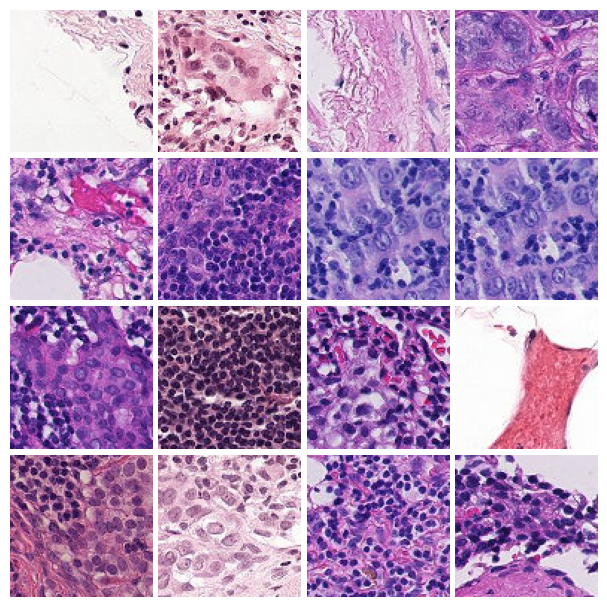

In [30]:
rows = 4
cols = 4
total = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(6, 6))
if rows * cols > 1:
    axes = axes.flatten()  # flatten for easier iteration

samples = [test_data[i] for i in range(total)]
for i, (img, label) in enumerate(samples):
    print(f"{i+1:>2d}: {test_data.classes[label]}")
    ax = axes[i] if total > 1 else axes
    ax.imshow(np.asarray(img))
    ax.axis('off')

# Hide any unused subplots.
for j in range(len(samples), total):
    axes[j].axis('off')

# Alternate method of adjusting padding:
# plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.tight_layout(pad=0.3)
plt.show()